In [1]:
import tensorflow as tf

data_dir = "ISIC2018_Task1-2_Training_Data\\"
batch_size = 32

list_ds = tf.data.Dataset.list_files(data_dir + "ISIC2018_Task1-2_Training_Input_x2\\*.jpg", shuffle=False)
for f in list_ds.take(5):
    print(f.numpy())

b'ISIC2018_Task1-2_Training_Data\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000000.jpg'
b'ISIC2018_Task1-2_Training_Data\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000001.jpg'
b'ISIC2018_Task1-2_Training_Data\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000003.jpg'
b'ISIC2018_Task1-2_Training_Data\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000004.jpg'
b'ISIC2018_Task1-2_Training_Data\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000006.jpg'


In [2]:
import pathlib

data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('ISIC2018_Task1-2_Training_Input_x2\\*.jpg')))

# Validation size: 0.2, Test size: 0.1
val_size = int(image_count * 0.2)
test_size = int(image_count * 0.1)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
test_ds = train_ds.take(test_size)
train_ds = train_ds.skip(test_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

1817
518
259


In [3]:
import os

# Process Dataset
AUTOTUNE = tf.data.AUTOTUNE

@tf.function
def get_mask(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    file_name = tf.strings.split(parts[-1], '.')[0]
    file_name = file_name + '_segmentation.png'
    return 'ISIC2018_Task1-2_Training_Data\\ISIC2018_Task1_Training_GroundTruth_x2\\'+file_name

@tf.function
def process_path(file_path):
    # Output raw image data from file paths
    img = tf.io.decode_jpeg(tf.io.read_file(file_path))
    mask = tf.io.decode_png(tf.io.read_file(get_mask(file_path)))
    img = tf.image.resize(img, [300, 400])
    mask = tf.image.resize(mask, [300, 400])
    return img, mask

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [4]:
import matplotlib.pyplot as plt

for img, mask in train_ds.take(9):
    print(img.numpy().shape)
    print(mask.numpy().shape)

(300, 400, 3)
(300, 400, 1)
(300, 400, 3)
(300, 400, 1)
(300, 400, 3)
(300, 400, 1)
(300, 400, 3)
(300, 400, 1)
(300, 400, 3)
(300, 400, 1)
(300, 400, 3)
(300, 400, 1)
(300, 400, 3)
(300, 400, 1)
(300, 400, 3)
(300, 400, 1)
(300, 400, 3)
(300, 400, 1)


In [5]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=200)
    ds = ds.batch(32)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [6]:
for img, mask in train_ds.take(1):
    print(img.numpy().shape)
    print(mask.numpy().shape)

(32, 300, 400, 3)
(32, 300, 400, 1)


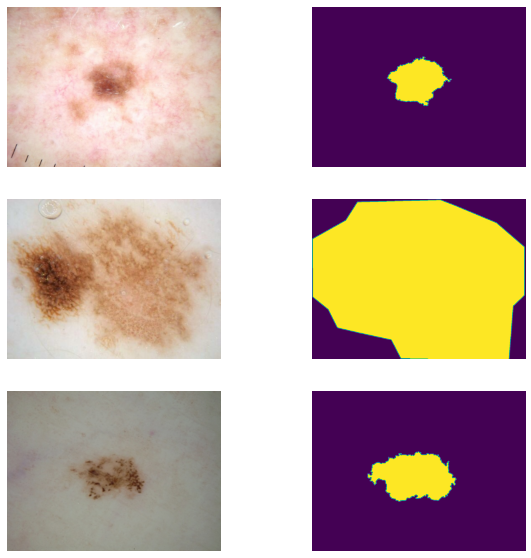

In [7]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in [1,3,5]:
    ax = plt.subplot(3, 2, i)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(label_batch[i].numpy().astype("uint8"))
    plt.axis("off")